### Comparing Aggregate Models for Regression

This try-it focuses on utilizing ensemble models in a regression setting.  Much like you have used individual classification estimators to form an ensemble of estimators -- here your goal is to explore ensembles for regression models.  As with your earlier assignment, you will use scikitlearn to carry out the ensembles using the `VotingRegressor`.   


#### Dataset and Task

Below, a dataset containing census information on individuals and their hourly wage is loaded using the `fetch_openml` function.  OpenML is another repository for datasets [here](https://www.openml.org/).  Your task is to use ensemble methods to explore predicting the `wage` column of the data.  Your ensemble should at the very least consider the following models:

- `LinearRegression` -- perhaps you even want the `TransformedTargetRegressor` here.
- `KNeighborsRegressor`
- `DecisionTreeRegressor`
- `Ridge`
- `SVR`

Tune the `VotingRegressor` to try to optimize the prediction performance and determine if the wisdom of the crowd performed better in this setting than any of the individual models themselves.  Report back on your findings and discuss the interpretability of your findings.  Is there a way to determine what features mattered in predicting wages?

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import root_mean_squared_error

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [12]:
df = fetch_openml(data_id=534, as_frame=True).frame

In [35]:
df

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married
...,...,...,...,...,...,...,...,...,...,...,...
529,18,no,male,5,not_member,11.36,29,White,Professional,Other,Unmarried
530,12,no,female,33,not_member,6.10,51,Other,Professional,Other,Married
531,17,no,female,25,member,23.25,48,Other,Professional,Other,Married
532,12,yes,male,13,member,19.88,31,White,Professional,Other,Married


In [14]:
X, y = df.drop("WAGE", axis=1), df["WAGE"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
model_names = [
    "LinearRegression",
    "KNeighborsRegressor",
    "DecisionTreeRegressor",
    "Ridge",
    "SVR",
]

In [47]:
list(df.select_dtypes(include="category").columns)

['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']

In [28]:
transformer = make_column_transformer(
    (
        OneHotEncoder(drop="if_binary"),
        list(df.select_dtypes(include="category").columns),
    ),
    remainder=StandardScaler(),
)

In [65]:
rmse = []
preds = {}
for model_name in model_names:
    model = eval(model_name)()
    pipeline = Pipeline([("transformer", transformer), ("regressor", model)]).fit(
        X_train, y_train
    )
    y_pred = pipeline.predict(X_test)
    score = pipeline.score(X_test, y_test)
    rmse.append(root_mean_squared_error(y_test, y_pred))
    preds[model_name] = y_pred

In [66]:
rmse_df = pd.DataFrame([rmse], columns=model_names)
rmse_df

,LinearRegression,KNeighborsRegressor,DecisionTreeRegressor,Ridge,SVR
0,4.223552,4.335423,5.902305,4.221121,4.319645


In [62]:
preds_df = pd.DataFrame(preds)
preds_df

,LinearRegression,KNeighborsRegressor,DecisionTreeRegressor,Ridge,SVR
0,8.642802,7.840,4.00,8.694104,8.337933
1,8.101087,7.092,6.50,8.106868,5.513556
2,8.874827,9.044,9.36,8.873333,7.329740
3,8.316683,8.200,8.75,8.339551,8.716015
4,10.501484,9.232,13.07,10.474319,7.708002
...,...,...,...,...,...
129,6.244204,4.590,2.85,6.268863,4.209064
130,9.319739,8.672,12.00,9.316490,8.218995
131,5.175126,7.348,3.51,5.216034,5.899424
132,5.191299,5.786,8.75,5.231856,6.008632


In [63]:
preds_df["EnsembleAverage"] = preds_df.mean(axis="columns")
preds_df

,LinearRegression,KNeighborsRegressor,DecisionTreeRegressor,Ridge,SVR,EnsembleAverage
0,8.642802,7.840,4.00,8.694104,8.337933,7.502968
1,8.101087,7.092,6.50,8.106868,5.513556,7.062702
2,8.874827,9.044,9.36,8.873333,7.329740,8.696380
3,8.316683,8.200,8.75,8.339551,8.716015,8.464450
4,10.501484,9.232,13.07,10.474319,7.708002,10.197161
...,...,...,...,...,...,...
129,6.244204,4.590,2.85,6.268863,4.209064,4.832426
130,9.319739,8.672,12.00,9.316490,8.218995,9.505445
131,5.175126,7.348,3.51,5.216034,5.899424,5.429717
132,5.191299,5.786,8.75,5.231856,6.008632,6.193557


In [67]:
results_df["EnsembleAverage"] = root_mean_
    squared_error(y_test, preds_df["EnsembleAverage"])

results_df

,LinearRegression,KNeighborsRegressor,DecisionTreeRegressor,Ridge,SVR,EnsembleAverage
rmse,4.223552,4.335423,6.857672,4.221121,4.319645,4.394921


Text(0, 0.5, 'Ensemble-Predicted Wages')

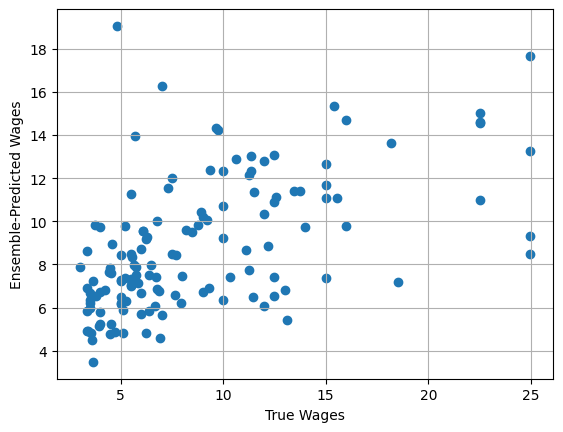

In [70]:
plt.scatter(y_test, preds_df["EnsembleAverage"])
plt.grid(True)
plt.xlabel("True Wages")
plt.ylabel("Ensemble-Predicted Wages")